In [4]:
# Initialize Otter
import otter
grader = otter.Notebook("Homework2.ipynb")

# Sentiment Analysis using Naive Bayes

In [5]:
import re
import string
import random
from collections import Counter

# pip install nltk
import nltk
import pandas as pd
import numpy as np
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import otter

grader = otter.Notebook()
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tagez\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Part 1: Data Preprocessing

In [6]:
def clean_data(review):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    review = review.lower()

    review = emoji_pattern.sub(r'', review)   

    #Remove contractions
    review=re.sub("isn't", "is not", review)
    review=re.sub("he's", "he is", review)
    review=re.sub("what's", "what is", review)
    review=re.sub("it's", "it is", review)
    review=re.sub("couldn't", "could not", review)
    review=re.sub("wouldn't", "would not", review)
    review=re.sub("can't", "cannot", review)
    review=re.sub("we're", "we are", review)
    review=re.sub("aren't", "are not", review)
    review=re.sub("i'm", "i am", review)
    review=re.sub("you're", "you are", review)
    review=re.sub("she's", "she is", review)
    review=re.sub("wasn't", "was not", review)
    review=re.sub("they're", "they are", review)
    review=re.sub("hasn't", "has not", review)
    review=re.sub("that's", "that is", review)
    review=re.sub("here's", "here is", review)
    review=re.sub("who's", "who is", review)
    review=re.sub("there's", "there is", review)
    review=re.sub("weren't", "were not", review)
    review=re.sub("haven't", "have not", review)
    review=re.sub("don't", "do not", review)
    review=re.sub("hadn't", "had not", review)
    review=re.sub("won't", "will not", review)
    review=re.sub("did't", "did not", review)
    review=re.sub("doesn't", "does not", review)
    review=re.sub("shouldn't", "should not", review)

    #Remove links
    review = re.sub('https?://\S+|www\.\S+', '', review)

    #Remove non alphabetic characters
    review = re.sub(r'\n', ' ', review)
    review = re.sub(r'[^a-zA-Z\s]', '', review)

    return review

In [7]:
# read in and clean data
data = pd.read_csv("IMDB Dataset.csv")
cleaned_data = data['review'].apply(clean_data)

cleaned_data = pd.DataFrame(cleaned_data)
cleaned_data['sentiment'] = data['sentiment']

In [8]:
# remove stop words
# this will take a long time to run, likely at least 10 minutes.
cleaned_data['no_sw'] = cleaned_data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [9]:
# find value counts of all words in all data points
counter = Counter()
for text in cleaned_data["no_sw"].values:
    for word in text.split():
        counter[word] += 1

# creates a set of the 10 most common words amongst all reviews
FREQWORDS = set([w for (w, wc) in counter.most_common(10)])

In [10]:
def remove_freqwords(text, freqwords):
    '''Given a review that has been cleaned, returns the review without the most frequently appearing words'''
    return ' '.join([word for word in text.split() if word not in (freqwords)])
        
# remove frequent words that do not add value to the model
cleaned_data["no_sw"] = cleaned_data["no_sw"].apply(lambda text: remove_freqwords(text, FREQWORDS))

In [11]:
# replace the sentiment with binary 0 or 1, prepare for model
tokenized_data = cleaned_data.drop(columns=['review'])
tokenized_data.columns = ['sentiment', 'review']

#convert the sentiment values to a binary 0 or 1
tokenized_data['sentiment'] = tokenized_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

#complete data preprocessing by changing the review format from a string of words to a list of strings containing individual words
tokenized_data['review'] = tokenized_data['review'].apply(lambda x: x.split())

Part 2: Naive Bayes Implementation

In [23]:
class NaiveBayesModel:
    '''Class representing the implementation of the Naive Bayes model'''

    def __init__(self) -> None:
        self.occurrence_table = {}
        self.probability_table = {}
        self.labels = []

    def train_model(self, data, labels):
        '''Runs the training process for the model, building the occurrence table and probability table'''

        self.labels = list(set(labels))
        self.build_occurrence_table(data, labels)
        self.build_probability_table()

        pass

    def build_occurrence_table(self, data, labels):
        '''Private function to create the occurrence table given the training data and labels'''

        # creates a nested dictionary table of frequencies based on the training data.
        # example format for the word 'word': {'word': {0: 3, 1: 15}}

        for review, sentiment in zip(data, labels):
            for word in review:
                if word not in self.occurrence_table:
                    self.occurrence_table[word] = {0: 0, 1: 0}
                
                self.occurrence_table[word][sentiment] += 1
        
        pass

    def build_probability_table(self):
        '''Private function to create the probability table based on the occurrence table'''

        # generates a table of probabilities based on the frequencies recorded in the occurrence table
        # example format for the word 'word': {'word': {0: 0.1667, 1: 0.8333}}

        for word, sentiment_counts in self.occurrence_table.items():
            total_occurrences = sum(sentiment_counts.values())

            probabilities = {}
            for sentiment, count in sentiment_counts.items():
                probabilities[sentiment] = count / total_occurrences

            self.probability_table[word] = probabilities

        pass

    def predict(self, variables):
        '''Takes a set of variables, and predicts the class they should belong to'''

        predictions = []

        for variable in variables:
            neg_probability = self.naive_bayes(0, variable)
            pos_probability = self.naive_bayes(1, variable)

            if (neg_probability == pos_probability):
                predicted_label = random.choice([0, 1])
            else:
                predicted_label = 0 if neg_probability > pos_probability else 1

            predictions.append(predicted_label)

        return predictions
    
    def naive_bayes(self, label, variable):
        probability = self.labels.count(label) / len(self.labels)

        for word in variable:
            if word in self.probability_table:
                probability *= self.probability_table[word][label]

        return probability

In [24]:
# perform a train/test split on the data
X=tokenized_data['review']
y=tokenized_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

# train and predict using the Naive Bayes model implementation
nb_model = NaiveBayesModel()
nb_model.train_model(X_train, y_train)
pred = nb_model.predict(X_test)
print(pred)

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 

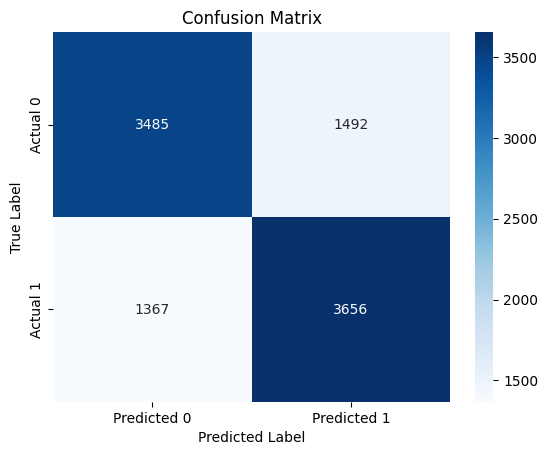

0.7141


In [26]:
#TODO - Create and display confusion matrices and evaluation metrics to prove the performance of your model.
# required: accuracy, recall, f-score

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, pred)

accuracy = metrics.accuracy_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f_score = metrics.f1_score(y_test, pred)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [15]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

C:\Users\tagez\AppData\Roaming\Python\Python311\site-packages\otter\check\notebook.py:470: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")


OSError: xelatex not found on PATH, if you have not installed xelatex you may need to do so. Find further instructions at https://nbconvert.readthedocs.io/en/latest/install.html#installing-tex.